In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import sys
from sklearn.metrics import make_scorer
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import recall_score # métrica de evaluación
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import validation_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import sys


sys.path.insert(0, '../../Code/')
from Plots import plt_validation_curve




def roc_curves(clf_list, X_test, y_test, prob=0.5):
    plt.figure(figsize=(10, 10))
    for clf in clf_list:
        fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
        auc_val = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=str(clf)+", AUC:{:.2f}".format(auc_val))


    plt.plot([0, 1], [0, 1], linestyle='--', color='black')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()

    plt.xlim([0, 1])
    plt.ylim([0, 1])

    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()


In [2]:
clf_list = []

## Árboles de clasificación

Tomamos un subconjunto de columnas y generamos una puntuacion crediticia denominada "borrower_score_"

In [3]:
outcome = 'outcome'
df = pd.read_csv("../../datasets/raw_loan_data.csv.gz")
df.loc[df[outcome]=="paid off",[outcome]] = "aPaidOff"                   


In [4]:
le = LabelEncoder()
le.fit(df[outcome])
df.loc[:,[outcome]] = le.transform(df[outcome]).astype(int)

In [5]:
le.classes_

array(['aPaidOff', 'default'], dtype=object)

In [6]:
df[outcome] = df[outcome].astype(int)
le.inverse_transform(df[outcome])

array(['default', 'default', 'default', ..., 'aPaidOff', 'aPaidOff',
       'aPaidOff'], dtype=object)

In [7]:
df.drop(columns=["Unnamed: 0", "status"], inplace=True)
predictors = ['dti', 'revol_bal', 'revol_util', 'open_acc', 
              'delinq_2yrs_zero', 'pub_rec_zero']


 revol_bal: total credit revolving balance, Saldo total de crédito renovable </BR>
 revol_util: percent of available credit being used </BR>
 pub_rec_zero: no derogatory public records </BR>


In [8]:
df[predictors]

,dti,revol_bal,revol_util,open_acc,delinq_2yrs_zero,pub_rec_zero
0,1.00,1687,9.4,3,1,1
1,5.55,5210,32.6,11,1,1
2,18.08,9279,36.5,2,1,1
3,10.08,10452,91.7,4,1,1
4,7.06,11997,55.5,14,1,1
...,...,...,...,...,...,...
45337,18.97,9725,58.2,9,1,0
45338,13.24,4925,40.7,13,0,1
45339,7.95,6574,73.0,8,1,1
45340,26.91,10303,32.4,10,1,1


## Creamos una columna via KNN con la puntuación crediticia

In [9]:
# Esto no es del todo correcto, deberia ejecutarlo unicamente con el bloque de entrenamiento.
# luego aplicar el transform a los datos de test con le ajuste que hice con entrenamiento.
col_num = ["dti", "revol_bal", "revol_util", "open_acc"]
dfc = df.copy()
dfc.loc[:, col_num] = StandardScaler().fit_transform(df[col_num])
X = dfc[predictors]
y = dfc[outcome]
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)
df.loc[:,'borrower_score_'] = knn.predict_proba(X)[:, 1]
del dfc

In [10]:
df.head()

,loan_amnt,term,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,purpose,home_ownership,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,outcome,emp_length,borrower_score_
0,2500,60 months,30000,1.00,2.39320,1687,9.4,car,RENT,1,1,3,4.8,1,1,0.35
1,5600,60 months,40000,5.55,4.57170,5210,32.6,small_business,OWN,1,1,11,1.4,1,5,0.35
2,5375,60 months,15000,18.08,9.71600,9279,36.5,other,RENT,1,1,2,6.0,1,1,0.50
3,9000,36 months,30000,10.08,12.21520,10452,91.7,debt_consolidation,RENT,1,1,4,4.2,1,1,0.55
4,10000,36 months,100000,7.06,3.90888,11997,55.5,other,RENT,1,1,14,5.4,1,4,0.55


In [10]:
cols_pred = list(df.columns.drop(outcome))
#cols_pred.remove('borrower_score_')

In [11]:
X = pd.get_dummies(df[cols_pred])
y = df[outcome]


In [14]:
## Generacion del modelo de árbol de clasificación

Arbitrariamente indico profundidad=15, ¿Es aceptable este número o estoy sobreajustando o subajustando el modelo?



In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3, test_size=0.3)
model = DecisionTreeClassifier(max_depth=15)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

              precision    recall  f1-score   support

           0       0.60      0.63      0.61      6720
           1       0.62      0.59      0.60      6883

    accuracy                           0.61     13603
   macro avg       0.61      0.61      0.61     13603
weighted avg       0.61      0.61      0.61     13603



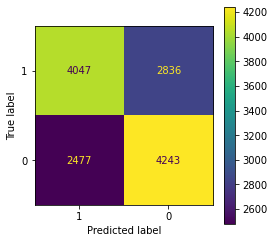

In [13]:
cm = confusion_matrix(y_test, y_pred)
cm = np.rot90(cm, 2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.flip(model.classes_))
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax)
print(classification_report(y_test, y_pred))
clf_list.append(model)

La columna 'borrower_score_' (Generada via KNN) parece ser la preferida del árbol 

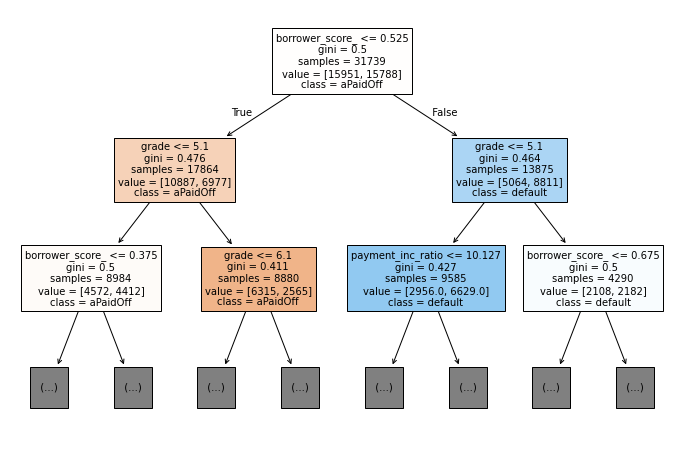

In [14]:
plt.figure(figsize=(12, 8))
plot_tree(model, fontsize=10, 
          filled=True, 
          feature_names=model.feature_names_in_, 
          class_names=le.inverse_transform(model.classes_),
          max_depth=2)
plt.show()

Veamos las curvas de validacion, veamos si tenemos alguna idea de donde esta el óptimo en términos de profundidad 

In [15]:
max_depths = np.arange(2,15)
# Calcular las curvas de validación
train_scores, valid_scores = validation_curve(model, X_train, y_train, 
                                              param_name="max_depth", 
                                              param_range=max_depths, 
                                              scoring="accuracy", 
                                              cv=5)

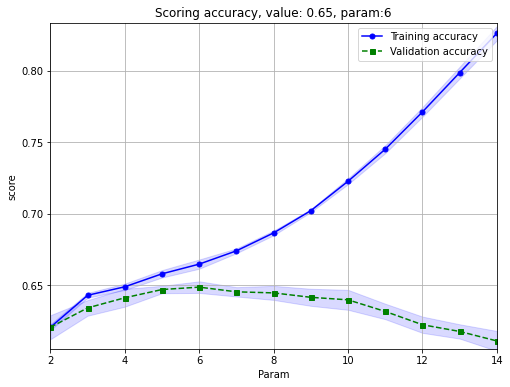

In [19]:
plt_validation_curve(max_depths, train_scores, valid_scores, scoring='accuracy')

La profundidad parece estar entre 5 y 6, no mas, a partir de 7 y 8 las curvas se separan

# Validación Cruzada.

Una herramienta contra la mala suerte.

Probemos con 6 de profundidad

In [16]:
model = DecisionTreeClassifier(max_depth=6)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

              precision    recall  f1-score   support

           0       0.66      0.60      0.63      6720
           1       0.64      0.70      0.67      6883

    accuracy                           0.65     13603
   macro avg       0.65      0.65      0.65     13603
weighted avg       0.65      0.65      0.65     13603



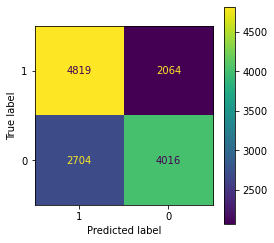

In [17]:
cm = confusion_matrix(y_test, y_pred)
cm = np.rot90(cm, 2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.flip(model.classes_))
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax)
print(classification_report(y_test, y_pred))
clf_list.append(model)

Es real o solo fue resultado de el azar en la selección. Usamos validación cruzada para confirmar el resultado.

In [18]:
"""Si los datos de entrenamiento son escasos, el error en test puede ser muy variable, 
dependiendo de las muestras incluidas en el conjunto de entrenamiento y el conjunto de test."""
nFolds = 3
kf = StratifiedKFold (n_splits = nFolds, shuffle = True, random_state = 0)
depths = np.arange(2,15)
sMatrix = np.empty((len(depths), nFolds))
for n, i in zip(depths, range(0, len(depths))):
    for (train_index, test_index), j in zip(kf.split(X_train, y_train), range(0, nFolds)):
        X_local_train, X_local_test = X_train.iloc[train_index], X_train.iloc[test_index]
        y_local_train, y_local_test = y_train.iloc[train_index], y_train.iloc[test_index]
        model = DecisionTreeClassifier(max_depth=n)
        model.fit(X_local_train, y_local_train)
        sMatrix[i, j] = model.score(X_local_test, y_local_test)

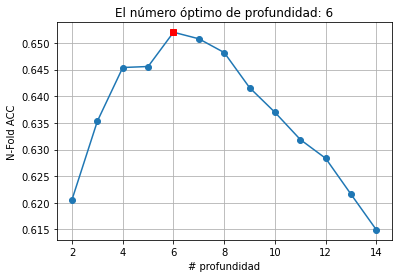

In [19]:
accVector = np.mean (sMatrix, axis = 1)
accStd = np.std (sMatrix, axis = 1)
idx = np.argmax (accVector)
n = depths[idx]
plt.plot (list(depths), accVector, '-o')
plt.plot (depths[idx], accVector[idx], 'rs')
plt.title ('El número óptimo de profundidad: %d' % n)
plt.xlabel ('# profundidad')
plt.ylabel ('N-Fold ACC')
plt.grid ()
plt.show ()

Esta muy claro, en 6 obtengo el punto máximo, pero hay muchos las hiperparametros para explorar y resulta tedioso la busqueda manual. GridSearchCV puede ayudar.

# Herramientas -GridSearchCV-

In [20]:
#Demora mas de 3 minutos
best_score = 0
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [4,5,6,7,8],
    'min_samples_split': [2, 4, 8, 10, 12, 14],
    'min_samples_leaf': [2, 4, 6, 8, 10]
}

model_gs = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1)
model_gs.fit(X_train, y_train)
model_gs.best_estimator_
clf_list.append(model_gs.best_estimator_)


              precision    recall  f1-score   support

           0       0.66      0.60      0.63      6720
           1       0.64      0.70      0.67      6883

    accuracy                           0.65     13603
   macro avg       0.65      0.65      0.65     13603
weighted avg       0.65      0.65      0.65     13603



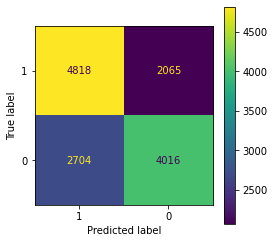

In [21]:
y_pred = (model_gs.predict_proba(X_test)[:,1]>0.5)
cm = confusion_matrix(y_test, y_pred)
cm = np.rot90(cm, 2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.flip(model.classes_))
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax)
print(classification_report(y_test, y_pred))

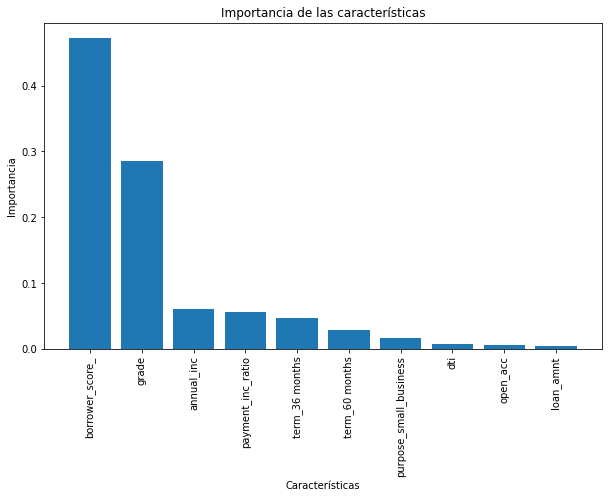

In [22]:
best  = model_gs.best_estimator_
feature_names = best.feature_names_in_
importances = best.feature_importances_
# Ordenar las características por importancia
indices = np.argsort(importances)[::-1]
sorted_feature_names = feature_names[indices]
sorted_importances = importances[indices]
max_values = 10
plt.figure(figsize=(10, 6))
plt.title("Importancia de las características")
plt.bar(range(max_values), sorted_importances[:max_values], align="center")
plt.xticks(range(max_values), sorted_feature_names[:max_values], rotation=90)
plt.xlabel("Características")
plt.ylabel("Importancia")
plt.show()

## Random Forest

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3, test_size=0.3)
model = RandomForestClassifier(max_depth=6)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

              precision    recall  f1-score   support

           0       0.66      0.64      0.65      6720
           1       0.66      0.68      0.67      6883

    accuracy                           0.66     13603
   macro avg       0.66      0.66      0.66     13603
weighted avg       0.66      0.66      0.66     13603



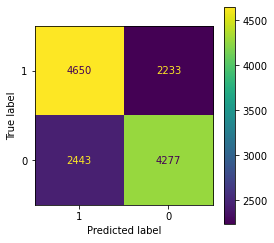

In [28]:
cm = confusion_matrix(y_test, y_pred)
cm = np.rot90(cm, 2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.flip(model.classes_))
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax)
print(classification_report(y_test, y_pred))
clf_list.append(model)

Aplico RandomizedSearchCV a un bosque aleatorio (Con GridSearchCV la cosa se puede volver un poco larga).

In [29]:
#Demora mas de 5 minutos
best_score = 0
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [3,4,5,6,7,8],
    'min_samples_split': [2, 4, 8, 10, 12, 14],
    'min_samples_leaf': [2, 4, 6, 8, 10],
    'max_features': ["sqrt", "log2", None], #Que cantidad de variables tomo?
    'n_estimators':[30,60,90,120,150,180]
    #'min_impurity_decrease': []
}
model_gs = RandomizedSearchCV(RandomForestClassifier(), param_grid, cv=3, n_jobs=-1)
model_gs.fit(X_train, y_train)

clf_list.append(model_gs.best_estimator_)


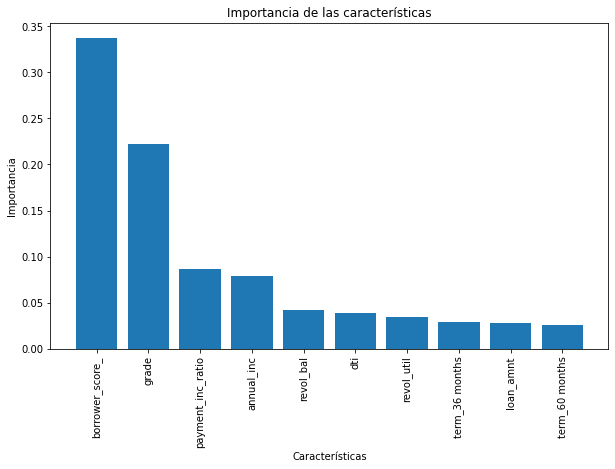

In [30]:
best  = model_gs.best_estimator_
feature_names = best.feature_names_in_
importances = best.feature_importances_
# Ordenar las características por importancia
indices = np.argsort(importances)[::-1]
sorted_feature_names = feature_names[indices]
sorted_importances = importances[indices]
max_values = 10
plt.figure(figsize=(10, 6))
plt.title("Importancia de las características")
plt.bar(range(max_values), sorted_importances[:max_values], align="center")
plt.xticks(range(max_values), sorted_feature_names[:max_values], rotation=90)
plt.xlabel("Características")
plt.ylabel("Importancia")
plt.show()

              precision    recall  f1-score   support

           0       0.66      0.64      0.65      6720
           1       0.66      0.68      0.67      6883

    accuracy                           0.66     13603
   macro avg       0.66      0.66      0.66     13603
weighted avg       0.66      0.66      0.66     13603



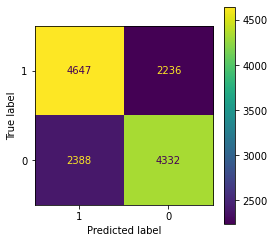

In [31]:
y_pred = (model_gs.predict_proba(X_test)[:,1]>0.5)
cm = confusion_matrix(y_test, y_pred)
cm = np.rot90(cm, 2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=np.flip(model.classes_))

fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax)
print(classification_report(y_test, y_pred))

## Curva ROC

Aun no tengo claro que clasificador funciona mejor, la curva ROC puede ser una herramienta visual que ayude al analisis

In [32]:
clf_list


[DecisionTreeClassifier(max_depth=15),
 DecisionTreeClassifier(max_depth=6),
 DecisionTreeClassifier(max_depth=6, min_samples_leaf=4),
 RandomForestClassifier(max_depth=6),
 RandomForestClassifier(criterion='log_loss', max_depth=8, max_features=None,
                        min_samples_leaf=2, min_samples_split=14,
                        n_estimators=90)]

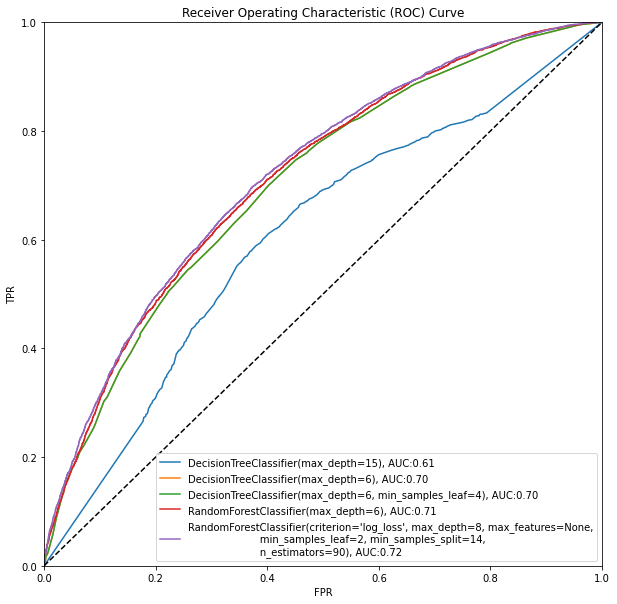

In [33]:
roc_curves(clf_list, X_test, y_test)

-----------------------

### Planteo que mi objetivo a maximizar es el recall, o sea quiero evitar clasificar a pagadores a futuros deudores, no quiero decir "paid off" cuando en realidad es "default", en otro terminos decir 0 (paid off) cuando debio ser 1 (default) o Falso Negativo (FN)

Estamos hablando de prestamos, no me preocupa negar prestamo a un pagador
pero me preocupa darle un prestamo a un defaulteador, la orden es, dada la ausencia de fondos, entregar prestamos solo cuando se esta muy seguro de que pagará. La clase positiva es default, por tanto con poca cuasi-probabilidad de default mi pronostico sera "default", prestamo denegado. Respecto al limite es a la inversa que con una enfermedad grave, donde no me importan clasificar como enfermo (1) a alguien sano (0). Aca, segun instrucciones no quiero clasificar como (1) a alquien (0)

In [30]:
#Demora casi 3 minutos
best_score = 0
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [3,4,5,6,7,8],
    'min_samples_split': [2, 4, 8, 10, 12, 14],
    'min_samples_leaf': [2, 4, 6, 8, 10],
    'max_features': ["sqrt", "log2", None], #Que cantidad de variables tomo?
    'n_estimators':[30,60,90,120,150,180]
    #'min_impurity_decrease': []
}

#Estamos hablando de prestamos, no me preocupa negar prestamo a un pagador
#pero me preocupa darle un prestamo a un defaulteador, entonces no quiero un 1
#donde debio existir un 0. Dicho de otro modo un Falso Positivo o FP

#Demostracion de como setear la clase positiva, normalmente 1
scorer = make_scorer(recall_score, pos_label=1)
model_gs = RandomizedSearchCV(RandomForestClassifier(), 
                              param_grid, 
                              cv=3,
                              scoring=scorer,                              
                              n_jobs=-1)
model_gs.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [3, 4, 5, 6, 7, 8],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [2, 4, 6, 8, 10],
                                        'min_samples_split': [2, 4, 8, 10, 12,
                                                              14],
                                        'n_estimators': [30, 60, 90, 120, 150,
                                                         180]},
                   scoring=make_scorer(recall_score, response_method='predict', pos_label=1))

              precision    recall  f1-score   support

           0       0.66      0.64      0.65      6720
           1       0.66      0.68      0.67      6883

    accuracy                           0.66     13603
   macro avg       0.66      0.66      0.66     13603
weighted avg       0.66      0.66      0.66     13603



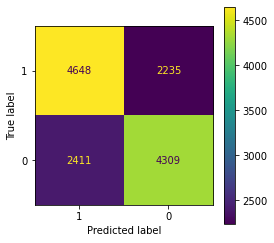

In [31]:
y_pred = model_gs.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm = np.rot90(cm, 2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=np.flip(model.classes_))

fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax)
print(classification_report(y_test, y_pred))

clf_list.append(model_gs.best_estimator_)

Ahora modifico el threshold hasta un punto que considero aceptable, la clase de interes es "default", voy bajando threshold pensando -si hay algun indicio (poca cuasi-probabilidad) de que defaultea lo dejo afuera.

              precision    recall  f1-score   support

           0       0.80      0.25      0.38      6720
           1       0.56      0.94      0.70      6883

    accuracy                           0.60     13603
   macro avg       0.68      0.60      0.54     13603
weighted avg       0.68      0.60      0.55     13603

6450 433 5018 1702


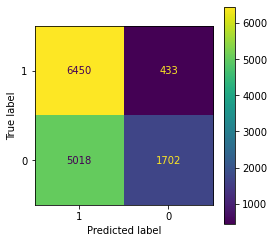

In [32]:
y_pred = (model_gs.predict_proba(X_test)[:,1]>0.29)
cm = confusion_matrix(y_test, y_pred)
cm = np.rot90(cm, 2)
tp, fn, fp, tn = cm.ravel()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.flip(model.classes_),)
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax)
print(classification_report(y_test, y_pred))
print(tp, fn, fp, tn)
#Recordemos recall TP/(TP+FN) , No quiero decir "No default" y es "Default"


Prob. Clasificadores

In [33]:
clf = clf_list[-1]
fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
roc_df = pd.DataFrame({'tpr':tpr, 'fpr': fpr})

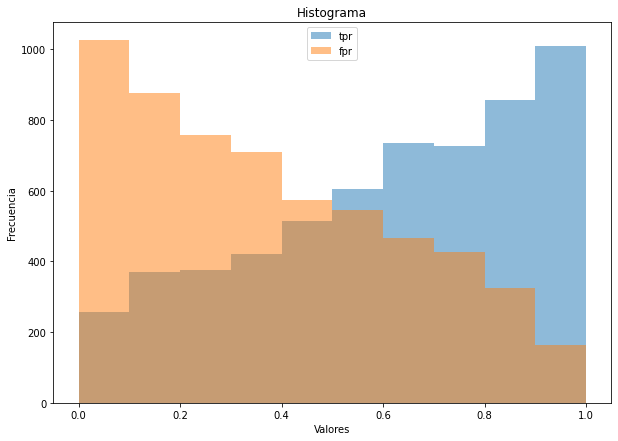

In [42]:

plt.figure(figsize=(10,7))
plt.hist(roc_df['tpr'], alpha=0.5, label='tpr')
plt.hist(roc_df['fpr'], alpha=0.5, label='fpr')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.title('Histograma')
plt.legend()
plt.show()